## Minimum spanning tree of all homes.
Read
https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Delaunay.html
https://networkx.org/documentation/networkx-1.10/reference/introduction.html#networkx-basics

https://networkx.org/documentation/networkx-1.10/reference/algorithms.mst.html


In [1]:
import time
import networkx as nx #tree stuff
import geopandas as gp
import pandas as pd
from math import radians, sin, cos, asin, sqrt
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt
from sklearn.cluster import OPTICS, cluster_optics_dbscan

In [45]:
#Set Parameters
epsilon=0.0005


In [46]:

# A sample of buildings, assumed to be buildings to place in ONE distribution grid

# TODO Check you have the datafile in the write place
buildings = 'SmallSample_OSMbuildings.geojson'

print('Loading data...')
# Prepare building data - read as geodataframe
gdf = gp.read_file(buildings)
# Get the number of rows (points) in the GeoDataFrame
no_points = gdf.shape[0]
gdf.head()


Loading data...


,osm_id,code,fclass,name,type,geometry
0,290668670,1500,building,None,None,"MULTIPOLYGON (((-11.02849 8.66825, -11.02849 8..."
1,290668671,1500,building,None,None,"MULTIPOLYGON (((-11.02868 8.66805, -11.02866 8..."
2,290668672,1500,building,None,None,"MULTIPOLYGON (((-11.02858 8.66796, -11.02855 8..."
3,290668673,1500,building,None,None,"MULTIPOLYGON (((-11.02869 8.66836, -11.02869 8..."
4,290668674,1500,building,None,None,"MULTIPOLYGON (((-11.02838 8.66822, -11.02836 8..."


In [47]:
# Get centroid points of building polygons
gdf['centroid'] = gdf['geometry'].centroid
# Break out lat and long into separate columns of GeoDataFrame
gdf['lon'] = gdf.centroid.x
gdf['lat'] = gdf.centroid.y
# Get lat and long columns from the GeoDataFrame and convert into a numpy array
coords = gdf.drop(['name', 'type', 'code', 'fclass', 'osm_id', 'geometry', 'centroid'], axis=1).to_numpy()
# You will get a warning.

C:\Users\Admin\AppData\Local\Temp/ipykernel_20924/2010564451.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf['geometry'].centroid
C:\Users\Admin\AppData\Local\Temp/ipykernel_20924/2010564451.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
C:\Users\Admin\AppData\Local\Temp/ipykernel_20924/2010564451.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


Building Map


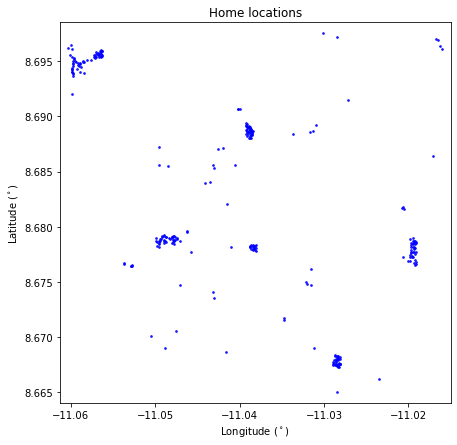

In [48]:
# Plot home locations
plt.figure(figsize=(7, 7))
plt.title('Home locations')
plt.scatter(x=coords[:, 0], y=coords[:, 1],color='b', s=3, alpha=0.8)
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
axes = plt.gca()
axes.set_xlim([min(coords[:, 0]) - 0.001, max(coords[:, 0]) + 0.001])
axes.set_ylim([min(coords[:, 1]) - 0.001, max(coords[:, 1]) + 0.001])

print("Building Map")

In [49]:
# Haversine formula for kilometer distance between two lat/long points
def haversine_dist_from_coords(lat1, lon1, lat2, lon2):
    # The math module contains a function named radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
    # calculate and return the result
    return c * r


In [50]:
def makeatree(coords,center,j): #3 variables, coords, centroid or not (use 1 for centroids, 0 for else), and i for group nr 
    if center==0:
        cc=np.copy(coords[clust.labels_==j])
    else:
        cc=np.copy(coords)
    no_points=cc.shape[0]
    #print('Calculating Delaunay triangulation and distance between Delaunay neighbours...')
    # Get Delauney triangulation of coordinates
    tri = Delaunay(cc)
    indices = tri.vertex_neighbor_vertices[0]
    indptr = tri.vertex_neighbor_vertices[1]

    # Instantiate dictionary to hold neighbors of each point & data-frame to hold distances between neighbours
    neighbors = {}
    locations = {}
    distances = pd.DataFrame(columns=["source", "dest", "distance"])

    # Get dictionary of neighbors of all points and a dictionary of locations of all points
    for k in range(0, no_points):
        neighbors[k] = indptr[indices[k]:indices[k+1]]
        locations[k] = cc[k][0], cc[k][1]

    # Get distances between all Delaunay neighbors
    for key, values in neighbors.items():
        for value in values:
            coord_1 = cc[key]
            coord_2 = cc[value]
            dist = haversine_dist_from_coords(coord_1[1], coord_1[0], coord_2[1], coord_2[0])
            distances = distances.append({"source": key, "dest": value, "distance": dist}, ignore_index=True)
            
    # Plot Delaunay triangulation
    #plt.figure(figsize=(7, 7))
    #plt.title('Delaunay Triangulation of Homes')
    #plt.triplot(cc[:, 0], cc[:, 1], tri.simplices)
    #plt.xlabel('Longitude ($^\circ$)')
    #plt.ylabel('Latitude ($^\circ$)')
    #plt.plot(cc[:, 0], cc[:, 1], 'o')
    #axes = plt.gca()
    #axes.set_xlim([min(cc[:, 0]) - 0.001, max(cc[:, 0]) + 0.001])
    #axes.set_ylim([min(cc[:, 1]) - 0.001, max(cc[:, 1]) + 0.001])
    
    #print('Creating a graph from this information (edge weight = distance)...')
    G = nx.Graph()
    for index, row in distances.iterrows():
        G.add_edge(row['source'], row['dest'], weight=row['distance'])

    #print('Calculating the minimum spanning tree of the graph...')
    T = nx.minimum_spanning_tree(G)

    edges = T.edges(data=True)
    weights = [x[2]['weight'] for x in edges]
    total_dist = sum(weights)

    #print('Number of nodes (buildings) in the graph: ', T.number_of_nodes())
    #print('Number of edges in the minimum spanning tree: ', T.number_of_edges()) #should be n-1
    #print('Total distance of minimum spanning tree (in km): ', total_dist)
    
    #print('Plotting results:')

    # Plot Minimum Spanning Tree made from Delaunay Triangulation
    plt.figure(figsize=(7, 7))
    labs={}
    for i in range(len(cc)):
        labs[i]=f"{i+1}"
    
    pos=locations
    if center==1:
        nx.draw_networkx(T, pos, with_labels=True, labels=labs, node_size=200, font_size=12, font_color="whitesmoke" )

    else:
        nx.draw_networkx(T, pos, with_labels=False, node_size=15, font_size=12)

    if center==0:
        plt.title(f'Minimum Spanning Tree of Delaunay Graph\n for cluster {j+1} \n (Edge Weight = Haversine Distance)')
    else:
        plt.title(f'Minimum Spanning Tree of Delaunay Graph\n between clusters \n (Edge Weight = Haversine Distance)')
    plt.xlabel('Longitude ($^\circ$)')
    plt.ylabel('Latitude ($^\circ$)')
    axes = plt.gca()
    axes.set_xlim([min(cc[:, 0]) - 0.001, max(cc[:, 0]) + 0.001])
    axes.set_ylim([min(cc[:, 1]) - 0.001, max(cc[:, 1]) + 0.001])
    axes.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    #axes.XTick=np.linspace(min(cc[:, 0]) - 0.001, max(cc[:, 0]) + 0.001, 12)
    #axes.YTick=np.linspace(min(cc[:, 1]) - 0.001, max(cc[:, 1]) + 0.001, 12)
   
    # Plot relative frequency of edge distances in minimum spanning tree
    plt.figure(figsize=(10, 4))
    plt.hist(weights, bins=200)
    plt.yscale("linear")
    plt.ylabel('Number of edges of this distance')
    plt.xlabel('Total distance (km)')

    plt.show()
    
    return T.number_of_nodes(), total_dist, weights

In [51]:
# Cluster the data
# TODO See how the parameters affect the result.

clust = OPTICS(min_samples=10, xi=0.5, min_cluster_size=.05)

# Run the fit
clust.fit(coords)
labelsOp = clust.labels_[clust.ordering_]

# See how many houses in each cluster. cluster -1 = outlier
(unique, counts) = np.unique(labelsOp, return_counts=True)
frequencies = np.asarray((unique, counts)).T
#print(frequencies)

#plot results
# plt.figure(figsize=(7, 7))

colors = ['g', 'r', 'b', 'y', 'c','m','olive','b','m']
labels = labelsOp
#for klass, color in zip(range(0, 8), colors):
#    plt.scatter(x=coords[labels == klass, 0], y=coords[labels == klass, 1],color=color, s=5, alpha=0.8)

# plot outliers
#plt.scatter(x=coords[clust.labels_ == -1, 0], y=coords[clust.labels_ == -1, 1],color='k', s=5, alpha=0.8)

coords_old=np.copy(coords)


Area containing of 7 clusters:


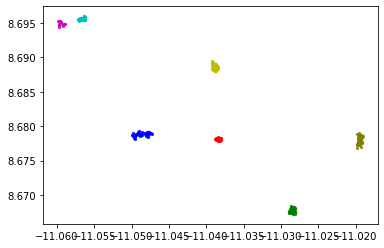

In [52]:

# TODO Now change range by changing eps in the DBSCAN equivalent.

labelsF = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=epsilon)

# See how many houses in each cluster. -1 = outlier
(unique, counts) = np.unique(labelsF, return_counts=True)
frequencies = np.asarray((unique, counts)).T
#print(frequencies)


#plt.figure(figsize=(10, 10))

colors = ['g', 'r', 'b', 'y', 'c','m','olive','b','m']
labels = labelsF
for klass, color in zip(range(0, len(unique)+1), colors): #double iteration simultaneously 
    plt.scatter(x=coords[labels == klass, 0], y=coords[labels == klass, 1],color=color, s=5, alpha=0.8) #select only some points in cluster


# plot outliers
#plt.scatter(x=coords[clust.labels_ == -1, 0], y=coords[clust.labels_ == -1, 1],color='k', s=1, alpha=0.8)

df = pd.DataFrame(coords)
df['Class'] = labelsF

#Find centroid
centroid= ([[0 for x in range(2)] for y in range(klass-1)]) 

for i in range(klass-1):
    centroid[i][0]=np.average(df[df["Class"]==i][0]) #x-coordinates
    centroid[i][1]=np.average(df[df["Class"]==i][1]) #y-coordinates

    centroid=np.array(centroid)

print(f"Area containing of {len(centroid)} clusters:")
clust.labels_=labelsF



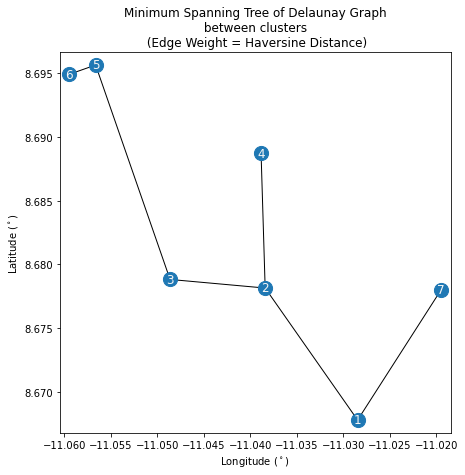

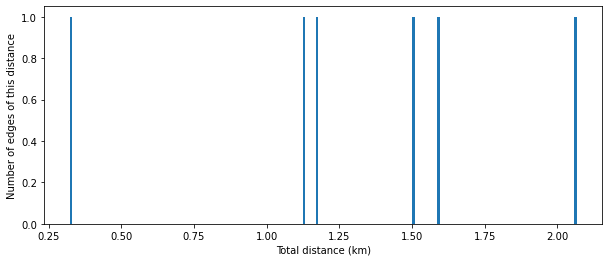

In [53]:
#Plot centroids 
klass
ngroups,tdists,tweight=makeatree(centroid,1,1)

Cluster Details:


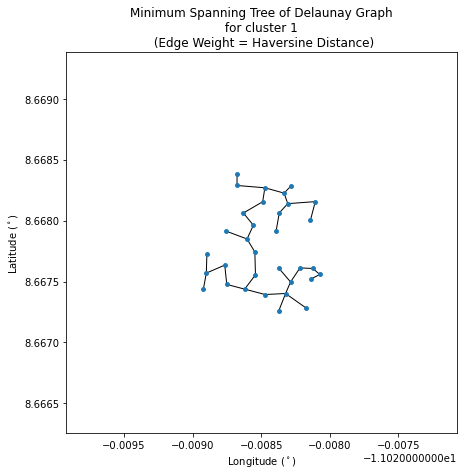

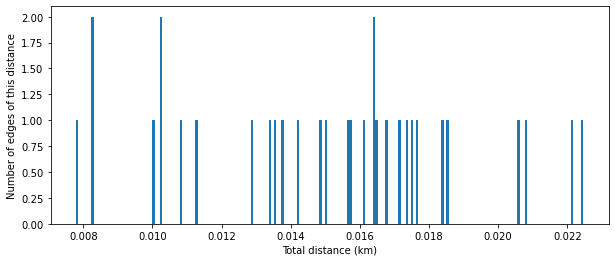

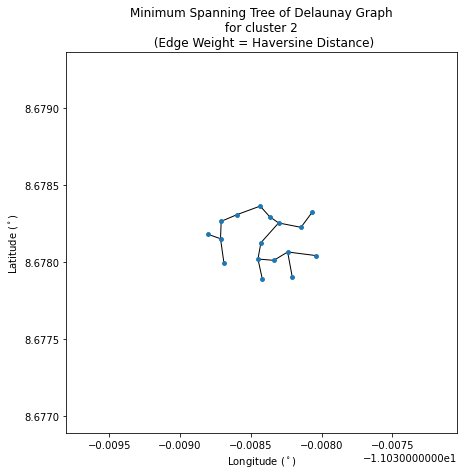

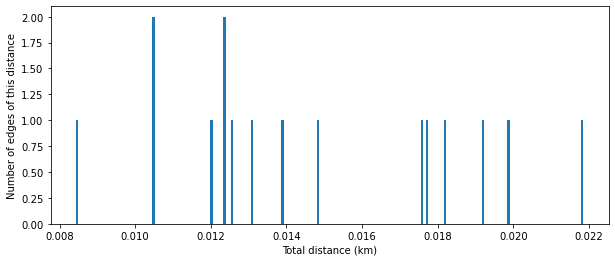

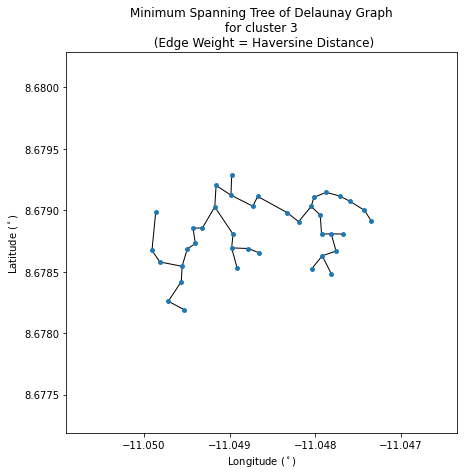

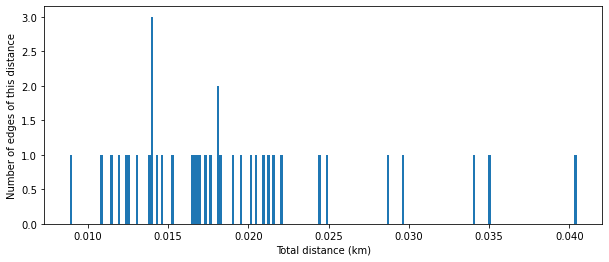

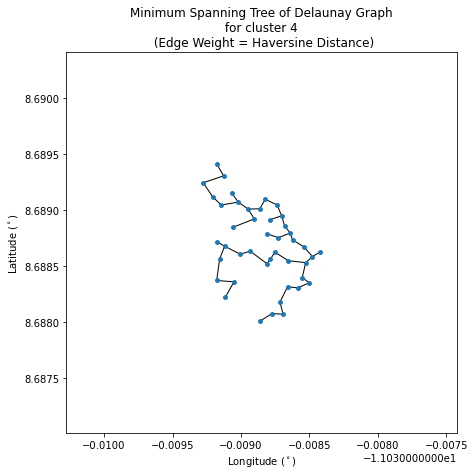

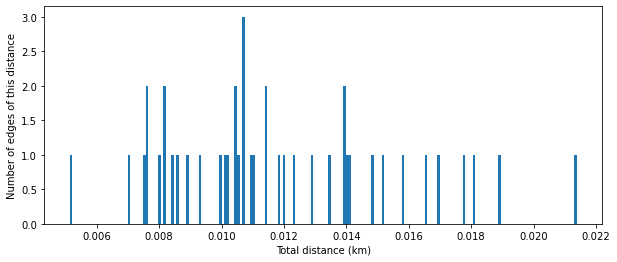

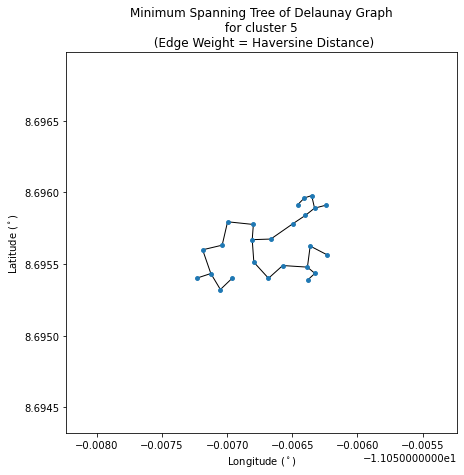

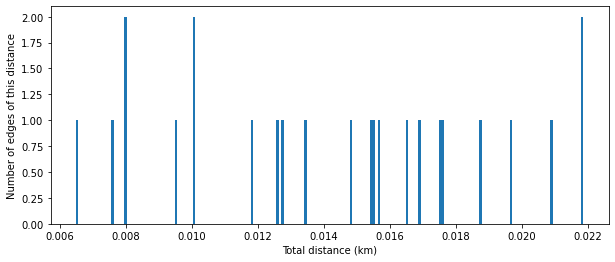

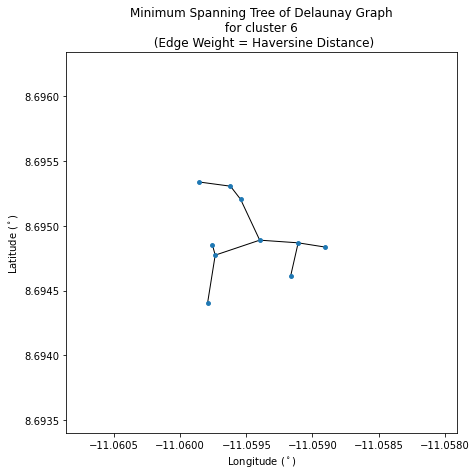

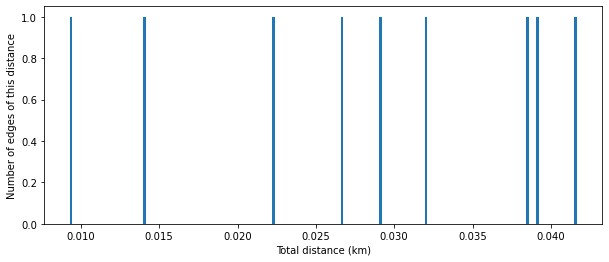

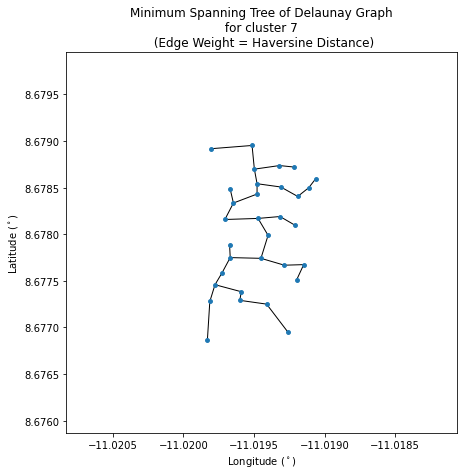

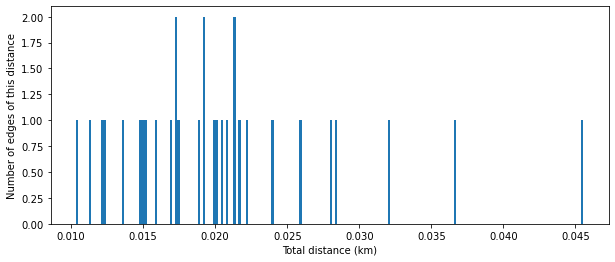

,Nr Nodes,Total Connection Distance
Cluster 1,33,0.480756
Cluster 2,17,0.234891
Cluster 3,39,0.720136
Cluster 4,44,0.507109
Cluster 5,25,0.343221
Cluster 6,10,0.252737
Cluster 7,32,0.634936
Interclusters,7,7.786902
Outliers,89,N/A


In [54]:
nodes=list(range(len(centroid)+2))
distances=list(range(len(centroid)+2))
names=list(range(len(centroid)+2))
weights=list(range(len(centroid)+2))

#Plot cluster info
print("Cluster Details:")
for i in range(len(centroid)):
    nodes[i], distances[i],weights[i] = makeatree(coords,0,i)
    names[i]=f"Cluster {i+1}"
nodes[i+1]=ngroups
distances[i+1]=tdists
names[i+1]="Interclusters"
weights[i+1]=tweight

names[i+2]="Outliers"
nodes[i+2]=0
distances[i+2]="N/A"

nodes[i+2]=len(gdf)-sum(nodes)+nodes[i+1]

df2 = pd.DataFrame({
    "Nr Nodes" : nodes,
    "Total Connection Distance" : distances
    })
df2.index=names
df2